In [3]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]
symbols = first_table.Symbol
first_table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [4]:
!pip install yfinance
!pip install talib-binary

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import time

start = time.time()
period_y = '11y'

df_X = yf.Ticker(symbols[0]).history(period=period_y).ffill()
df_X["Close_mom_sht"] = ta.MOM(df_X["Close"], timeperiod = 5)
df_X["Close_mom_mid"] = ta.MOM(df_X["Close"], timeperiod = 25)
df_X["Close_mom_lng"] = ta.MOM(df_X["Close"], timeperiod = 75)
df_X["Close_rsi"] = ta.RSI(df_X["Close"])
df_X["Close_Price_NATR"] = ta.NATR(df_X["High"], df_X["Low"], df_X["Close"])
df_X["Close"] = ta.ROCP(df_X["Close"], timeperiod = 1)
df_X = df_X.filter(regex='Close', axis = 1)
df_X.columns = ["MMM_" + c for c in df_X.columns]

for smb in symbols[1:]:
    new_df_X = yf.Ticker(smb).history(period=period_y).ffill()
    if len(new_df_X) == 0:
        continue
    if (new_df_X.index[0] != df_X.index[0]):
        continue
    new_df_X["Close_mom_sht"] = ta.MOM(new_df_X["Close"], timeperiod = 5)
    new_df_X["Close_mom_mid"] = ta.MOM(new_df_X["Close"], timeperiod = 25)
    new_df_X["Close_mom_lng"] = ta.MOM(new_df_X["Close"], timeperiod = 75)
    new_df_X["Close_rsi"] = ta.RSI(new_df_X["Close"])
    new_df_X["Close_Price_NATR"] = ta.NATR(new_df_X["High"], new_df_X["Low"], new_df_X["Close"])
    new_df_X["Close"] = ta.ROCP(new_df_X["Close"], timeperiod = 1)
    new_df_X = new_df_X.filter(regex='Close', axis = 1)
    new_df_X.columns = [smb + "_" + c for c in new_df_X.columns]
    df_X = df_X.join(new_df_X, how = "outer")
print(f"{(time.time() - start) / 60: 0.2f} min.")

- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
 2.31 min.


In [6]:
start = time.time()

df_X_low_cor = df_X.copy()
print(df_X_low_cor.shape)
cor = df_X_low_cor.filter(regex='Close$', axis = 1).corr()
cor_n_diag = cor - np.diag(np.ones(cor.shape[0]))
print(((cor_n_diag > 0.8).sum() > 0).sum())
print(((cor_n_diag > 0.7).sum() > 0).sum())

while (cor_n_diag > 0.7).sum().sum() > 0:
    candidates = cor_n_diag[np.any(cor_n_diag == cor_n_diag.max().max(), axis = 1)].mean(axis = 1)
    col_del_names = candidates[candidates == candidates.max()]
    col_del_names = df_X_low_cor.filter(regex = col_del_names.index.values[0], axis = 1).columns.values

    df_X_low_cor = df_X_low_cor.loc[:, [not cl in col_del_names for cl in df_X_low_cor.columns.values]]
    cor = df_X_low_cor.filter(regex='Close$', axis = 1).corr()
    cor_n_diag = cor - np.diag(np.ones(cor.shape[0]))

print(f"{(time.time() - start) / 60: 0.2f} min.")
print(df_X_low_cor.shape)
print(((cor_n_diag > 0.7).sum() > 0).sum())

(2769, 2676)
93
223
 1.69 min.
(2769, 1428)
0


In [7]:
df_X = df_X_low_cor
print(df_X.isna().sum().sum())
df_X = df_X.ffill()
print(df_X.head(6))

df_X = df_X.dropna()
print(df_X.shape)
print(df_X.head(6))

31892
            MMM_Close  MMM_Close_mom_sht  MMM_Close_mom_mid  \
Date                                                          
2011-05-09        NaN                NaN                NaN   
2011-05-10  -0.002917                NaN                NaN   
2011-05-11  -0.001985                NaN                NaN   
2011-05-12   0.011830                NaN                NaN   
2011-05-13  -0.006622                NaN                NaN   
2011-05-16  -0.005728          -0.390755                NaN   

            MMM_Close_mom_lng  MMM_Close_rsi  MMM_Close_Price_NATR  AOS_Close  \
Date                                                                            
2011-05-09                NaN            NaN                   NaN        NaN   
2011-05-10                NaN            NaN                   NaN   0.013084   
2011-05-11                NaN            NaN                   NaN  -0.019142   
2011-05-12                NaN            NaN                   NaN  -0.015049   
201

In [8]:
import pandas_datareader.data as web
import datetime

SP500 = web.DataReader(['sp500'], 'fred', df_X.index[0], datetime.datetime(2022, 5, 2))
print(SP500.isna().sum())
SP500 = SP500.dropna()
print(SP500)

SP500['sp500'] = ta.ROCP(SP500['sp500'], timeperiod = 1)
y_ind = SP500.index[1:-2]
SP500_t2 = SP500.iloc[3:, :].rename(columns = {"sp500": "sp500_t2"})
SP500_t2.index = y_ind
df = SP500_t2.join(SP500).join(df_X)
print(df.isna().sum().sum())
print(df)

sp500    92
dtype: int64
              sp500
DATE               
2012-05-07  1369.58
2012-05-08  1363.72
2012-05-09  1354.58
2012-05-10  1357.99
2012-05-11  1353.39
...             ...
2022-04-26  4175.20
2022-04-27  4183.96
2022-04-28  4287.50
2022-04-29  4131.93
2022-05-02  4155.38

[2514 rows x 1 columns]
0
            sp500_t2     sp500  MMM_Close  MMM_Close_mom_sht  \
DATE                                                           
2012-05-08  0.002517 -0.004279  -0.005113          -1.544144   
2012-05-09 -0.003387 -0.006702  -0.003313          -1.703148   
2012-05-10 -0.011113  0.002517  -0.001604          -1.710686   
2012-05-11 -0.005746 -0.003387  -0.004591          -1.468445   
2012-05-14 -0.004404 -0.011113  -0.010377          -1.650162   
...              ...       ...        ...                ...   
2022-04-22 -0.028146 -0.027740  -0.017131           1.789993   
2022-04-25  0.002098  0.005698  -0.003821           2.420013   
2022-04-26  0.024747 -0.028146  -0.029475       

In [9]:
df.shape

n_t = 3
df_org = df.copy()

df_ind = df_org.index[:-1]
df_t_1 = df_org.iloc[1:, 1:]
df_t_1.index = df_ind
df_t_1.columns = [c + "_t_1" for c in df_org.columns[1:]]
df = df.join(df_t_1, how = "inner")

for i in range(2, (n_t + 1)):
    df_ind = df_t_1.index[:-1]
    df_t_1 = df_t_1.iloc[1:, :]
    df_t_1.index = df_ind
    df_t_1.columns = [c + "_t_" + str(i) for c in df_org.columns[1:]]
    df = df.join(df_t_1, how = "inner")

print(df)

            sp500_t2     sp500  MMM_Close  MMM_Close_mom_sht  \
DATE                                                           
2012-05-08  0.002517 -0.004279  -0.005113          -1.544144   
2012-05-09 -0.003387 -0.006702  -0.003313          -1.703148   
2012-05-10 -0.011113  0.002517  -0.001604          -1.710686   
2012-05-11 -0.005746 -0.003387  -0.004591          -1.468445   
2012-05-14 -0.004404 -0.011113  -0.010377          -1.650162   
...              ...       ...        ...                ...   
2022-04-19 -0.014753  0.016058   0.026816          -0.019989   
2022-04-20 -0.027740 -0.000619   0.003264           2.009995   
2022-04-21  0.005698 -0.014753   0.007836           3.110001   
2022-04-22 -0.028146 -0.027740  -0.017131           1.789993   
2022-04-25  0.002098  0.005698  -0.003821           2.420013   

            MMM_Close_mom_mid  MMM_Close_mom_lng  MMM_Close_rsi  \
DATE                                                              
2012-05-08          -1.264091    

In [10]:
print(df.columns[:1430])

Index(['sp500_t2', 'sp500', 'MMM_Close', 'MMM_Close_mom_sht',
       'MMM_Close_mom_mid', 'MMM_Close_mom_lng', 'MMM_Close_rsi',
       'MMM_Close_Price_NATR', 'AOS_Close', 'AOS_Close_mom_sht',
       ...
       'YUM_Close_mom_mid', 'YUM_Close_mom_lng', 'YUM_Close_rsi',
       'YUM_Close_Price_NATR', 'ZBH_Close', 'ZBH_Close_mom_sht',
       'ZBH_Close_mom_mid', 'ZBH_Close_mom_lng', 'ZBH_Close_rsi',
       'ZBH_Close_Price_NATR'],
      dtype='object', length=1430)


In [11]:
import random
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, LSTM

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [12]:
n_train = int(np.round(df.shape[0] * 0.8))

df_train = df.iloc[:n_train, :]
df_test = df.iloc[n_train:, :]

sc = StandardScaler()
df_train_tf = sc.fit_transform(df_train.values)
df_test_tf = sc.transform(df_test.values)

In [113]:
def data_generator_lstm(df, window, batchsize):
  feature = np.empty((batchsize, 1429, window))
  target = np.empty((batchsize, 1))

  ite = 0
  while True:
    i = random.randint(window, len(df)-1)
    # for i in range(window, len(df)):
    onefeature = df[(i-window):i,1:1430]
    feature[ite] = onefeature.T

    target[ite] = df[i,0]

    ite += 1

    if ite == batchsize-1:
      yield feature, target
      ite = 0    

In [149]:
dropout_p = 0.1
lr_alpha = 0.05
window = 10

model = Sequential()
model.add(Dropout(dropout_p, input_shape = [1429, window]))

model.add(LSTM(256, return_sequences=True))
model.add(LeakyReLU(alpha=lr_alpha))
model.add(BatchNormalization())
model.add(Dropout(dropout_p))

model.add(LSTM(64))
model.add(LeakyReLU(alpha=lr_alpha))
model.add(BatchNormalization())
model.add(Dropout(dropout_p))

model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_102 (Dropout)       (None, 1429, 10)          0         
                                                                 
 lstm_22 (LSTM)              (None, 1429, 256)         273408    
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 1429, 256)         0         
                                                                 
 batch_normalization_86 (Bat  (None, 1429, 256)        1024      
 chNormalization)                                                
                                                                 
 dropout_103 (Dropout)       (None, 1429, 256)         0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                82176     
                                                     

In [150]:
seed_everything(0)
start = time.time()

n_epoch = 7
batchsize = 64

generator = data_generator_lstm(df_train_tf, window = window, batchsize = batchsize)
valid_generator = data_generator_lstm(df_test_tf, window = window, batchsize = batchsize)
train_steps = (len(df_train_tf) - window) // batchsize
test_steps = (len(df_test_tf) - window) // batchsize

hist = model.fit(generator, 
          steps_per_epoch = train_steps, 
          verbose = True, epochs=n_epoch, 
          validation_data=valid_generator,
          validation_steps = test_steps,
          )

print(f"{(time.time() - start) / 60: 0.2f} min.")

Epoch 1/7
31/31 [==============================] - 11s 228ms/step - loss: 1.9179 - mean_absolute_error: 0.9695 - val_loss: 1.1168 - val_mean_absolute_error: 0.7769
Epoch 2/7
31/31 [==============================] - 6s 207ms/step - loss: 1.2642 - mean_absolute_error: 0.7990 - val_loss: 1.0783 - val_mean_absolute_error: 0.7812
Epoch 3/7
31/31 [==============================] - 6s 206ms/step - loss: 1.3587 - mean_absolute_error: 0.7765 - val_loss: 0.7884 - val_mean_absolute_error: 0.6857
Epoch 4/7
31/31 [==============================] - 6s 207ms/step - loss: 1.3045 - mean_absolute_error: 0.7646 - val_loss: 0.9318 - val_mean_absolute_error: 0.7353
Epoch 5/7
31/31 [==============================] - 6s 206ms/step - loss: 1.1623 - mean_absolute_error: 0.7540 - val_loss: 0.9566 - val_mean_absolute_error: 0.7423
Epoch 6/7
31/31 [==============================] - 6s 207ms/step - loss: 1.2716 - mean_absolute_error: 0.7326 - val_loss: 0.8827 - val_mean_absolute_error: 0.7173
Epoch 7/7
31/31 [====

In [151]:
train_for_inv = np.concatenate((np.transpose([hist.history["mean_absolute_error"]]), df_train_tf[:n_epoch, 1:]), axis = 1)
test_for_inv = np.concatenate((np.transpose([hist.history["val_mean_absolute_error"]]), df_train_tf[:n_epoch, 1:]), axis = 1)
train_mae_org_sc = sc.inverse_transform(train_for_inv)[:, 0]
test_mae_org_sc = sc.inverse_transform(test_for_inv)[:, 0]

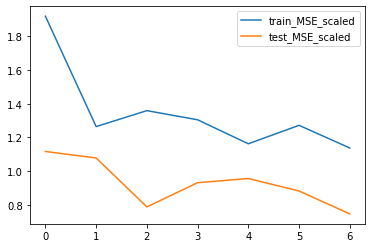

In [152]:
plt.plot(range(n_epoch), hist.history["loss"], label = "train_MSE_scaled");
plt.plot(range(n_epoch), hist.history["val_loss"], label = "test_MSE_scaled");
plt.legend()
plt.show()

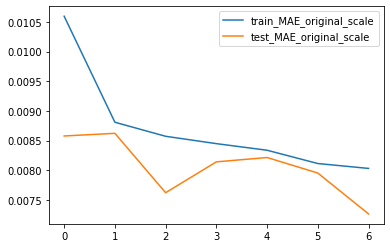

In [153]:
plt.plot(range(n_epoch), train_mae_org_sc, label = "train_MAE_original_scale");
plt.plot(range(n_epoch), test_mae_org_sc, label = "test_MAE_original_scale");
plt.legend()
plt.show()

In [154]:
from tqdm import tqdm
pred_for_inv_feature = np.empty((len(df_test_tf)-window, 1429, window))
for i in tqdm(range(window,len(df_test_tf))):
  pred_for_inv_feature[i-window] = df_test_tf[(i-window):i,1:1430].T
pred_for_inv = model.predict(pred_for_inv_feature)

100%|██████████| 492/492 [00:00<00:00, 26198.43it/s]


In [155]:
pred_for_inv = np.concatenate((pred_for_inv, df_test_tf[window:, 1:]), axis=1)

pred = sc.inverse_transform(pred_for_inv)[:,0]
y_test = df_test.iloc[:, 0]

pred_price = [100 * (pred[window] + 1)]
y_test_price = [100 * (y_test[window] + 1)]
for i in range(1, len(pred)):
    pred_price.append(pred_price[i-1] * (pred[i] + 1))
    y_test_price.append(y_test_price[i-1] * (y_test[i] + 1))

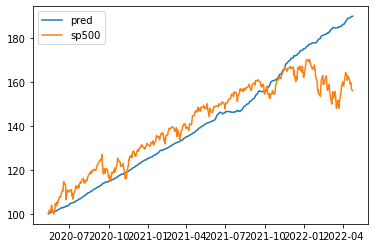

In [156]:
plt.plot(df_test.index[window:], pred_price, label = "pred");
plt.plot(df_test.index[window:], y_test_price, label = "sp500");
plt.legend()
plt.show()

In [157]:
start = time.time()

def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in tqdm(range(num_samples))]
    return np.hstack(preds)

pred_dist_feature = np.empty((len(df_test_tf)-window, 1429, window))
for i in tqdm(range(window, len(df_test_tf))):
  pred_dist_feature[i-window] = df_test_tf[(i-window):i, 1:1430].T

pred_dist = predict_dist(pred_dist_feature, model = model, num_samples = 101)

pred_mean = pred_dist.mean(axis=1)

pred_dist = pd.DataFrame(pred_dist)
pred_dist.index = df_test.index[window:]

for i in tqdm(range(pred_dist.shape[1])):
    pred_for_inv = np.concatenate((np.transpose([pred_dist.iloc[:, i]]), df_test_tf[window:, 1:]), axis = 1)
    pred_dist.iloc[:, i] = sc.inverse_transform(pred_for_inv)[:, 0]

pred_for_inv = np.concatenate((np.transpose([pred_mean]), df_test_tf[window:, 1:]), axis = 1)
pred_mean = sc.inverse_transform(pred_for_inv)[:, 0]

pred_05 = pred_dist.quantile(0.05, axis = 1)
pred_50 = pred_dist.quantile(0.5, axis = 1)
pred_95 = pred_dist.quantile(0.95, axis = 1)

pred_mean_price = [100 * (pred_mean[0] + 1)]
pred_05_price = [100 * (pred_05[0] + 1)]
pred_50_price = [100 * (pred_50[0] + 1)]
pred_95_price = [100 * (pred_95[0] + 1)]
for i in range(1, len(pred_mean)):
    pred_mean_price.append(pred_mean_price[i-1] * (pred_mean[i] + 1))
    pred_05_price.append(pred_05_price[i-1] * (pred_05[i] + 1))
    pred_50_price.append(pred_50_price[i-1] * (pred_50[i] + 1))
    pred_95_price.append(pred_95_price[i-1] * (pred_95[i] + 1))

print(f"{(time.time() - start) / 60: 0.2f} min.")

100%|██████████| 101/101 [00:01<00:00, 68.49it/s]

 0.44 min.


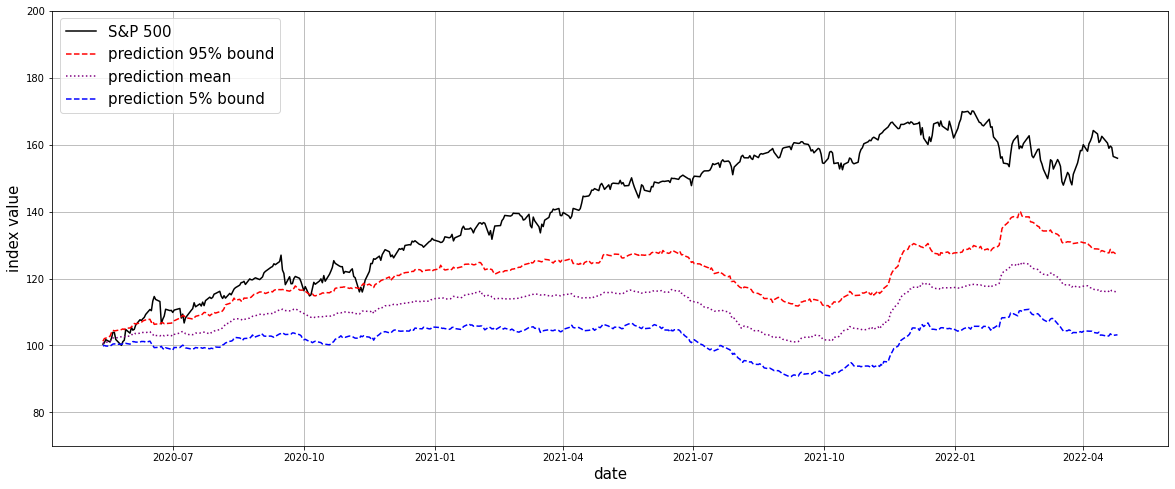

In [158]:
pred_dist_price = (pred_dist + 1)
pred_dist_price.iloc[0,:] = 100 * pred_dist_price.iloc[0,:]
pred_dist_price = pred_dist_price.cumprod()

pred_05_price = pred_dist_price.quantile(0.05, axis = 1)
pred_50_price = pred_dist_price.quantile(0.5, axis = 1)
pred_95_price = pred_dist_price.quantile(0.95, axis = 1)

pred_mean_price = [100 * (pred_mean[0] + 1)]
for i in range(1, len(pred_mean)):
    pred_mean_price.append(pred_mean_price[i-1] * (pred_mean[i] + 1))

plt.figure(figsize=(20,8))
plt.ylim([70, 200]);

plt.plot(df_test.index[window:], y_test_price, label = "S&P 500", color = "black");
plt.plot(df_test.index[window:], pred_95_price, label = "prediction 95% bound", linestyle = "dashed", color = "red");
plt.plot(df_test.index[window:], pred_mean_price, label = "prediction mean", linestyle = "dotted", color = "purple");
plt.plot(df_test.index[window:], pred_05_price, label = "prediction 5% bound", linestyle = "dashed", color = "blue");
plt.xlabel("date", size=15)
plt.ylabel("index value", size=15)
plt.grid()
plt.legend(prop={'size': 15})
plt.show()